In [1]:
import ee
import geemap
from geeRiverCL import *
import numpy as np
geemap.ee_initialize()

In [2]:
import geemap.chart as chart

In [3]:
import matplotlib.pyplot as plt

In [4]:
# roi
ltb = ee.FeatureCollection("projects/ee-alpha-luoyee1997/assets/LT").geometry()
# landsat
bandnames = ['Red', 'Green', 'Blue', 'NIR', 'SWIR1']
#imgLS = load_Landsat("projects/ee-alpha-luoyee1997/assets/LT", '2021-10-01', '2022-09-01').multiply(0.0000275).add(-0.2)
imgLS1 = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_023036_20220625').select(['SR_B4', 'SR_B3', 'SR_B2', 'SR_B5', 'SR_B6']).multiply(0.0000275).add(-0.2).rename(bandnames)
imgLS2 = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_023037_20220625').select(['SR_B4', 'SR_B3', 'SR_B2', 'SR_B5', 'SR_B6']).multiply(0.0000275).add(-0.2).rename(bandnames)
imgLS = ee.ImageCollection([imgLS1, imgLS2]).mosaic().clip(ltb)
crsLS = imgLS.projection().crs().getInfo()
sclLS = 30
# planet
imgPS = load_image('users/luoyee1997/geeRiver/LT/PlanetSR2', ['b1', 'b2', 'b3', 'b4'], ['Blue', 'Green', 'Red', 'NIR']).multiply(0.0001)
crsPS = imgPS.projection().crs().getInfo()
sclPS = 3

In [5]:
classPS = classification1(imgPS, 3, method='minDis')
classPS1 = classification1(imgPS, 3, method='RF')

In [6]:
classPS2 = classification2(imgPS, 3, method='RF')

In [27]:
classLS = classification1(imgLS, 3, method='minDis')
classLS1 = classification1(imgLS, 3, method='RF')

In [8]:
classLS2 = classification2(imgLS, 3, method='RF')

In [9]:
Map = geemap.Map()
vis = {
    'bands': ['Red', 'Green', 'Blue'],
    'min': 0,
    'max': 0.7042,
    'gamma': 2
}
Map.centerObject(imgPS, 12)
Map.addLayer(imgPS, vis, 'PS')

In [75]:
Map.addLayer(imgLS, vis, 'LS')

In [28]:
Map.addLayer(classPS1, {'min':1, 'max':3, 'palette': ['#0080FF', 'red', 'green']}, 'classPS1')
Map.addLayer(classPS, {'min':1, 'max':3, 'palette': ['#0080FF', 'red', 'green']}, 'classPS')
Map.addLayer(classLS1, {'min':1, 'max':3, 'palette': ['#0080FF', 'red', 'green']}, 'classLS1')
Map.addLayer(classLS, {'min':1, 'max':3, 'palette': ['#0080FF', 'red', 'green']}, 'classLS')

In [13]:
Map.addLayer(classLS2, {'min':1, 'max':3, 'palette': ['#0080FF', 'red', 'green']}, 'classLS2')

In [14]:
Map.addLayer(classPS2, {'min':1, 'max':3, 'palette': ['#0080FF', 'red', 'green']}, 'classPS2')

In [15]:
ndvi = imgPS.normalizedDifference(['NIR', 'Red']).rename('NDVI')
evi = Evi(imgPS).rename('EVI')

In [42]:
ndvi1 = imgLS.normalizedDifference(['NIR', 'Red']).rename('NDVI')
evi1 = Evi(imgLS).rename('EVI')

In [71]:
def plot_hist(img, ltb, name, scale=3, alpha=0.8):
    my_sample = img.clip(ltb).sample(ltb, numPixels=5000, scale=scale)
    l = my_sample.getInfo()['features']
    stat = [i['properties'][name] for i in l]
    plt.hist(stat, density=True, bins=100, alpha=alpha)

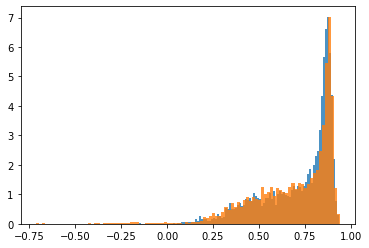

In [72]:
plot_hist(ndvi, ltb, 'NDVI')
plot_hist(ndvi1, ltb, 'NDVI', scale=30);

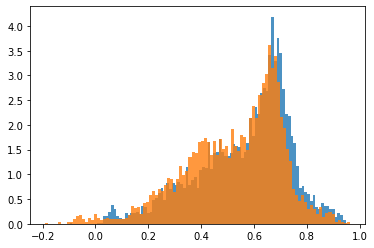

In [73]:
plot_hist(evi, ltb, 'EVI')
plot_hist(evi1, ltb, 'EVI', scale=30);

In [17]:
my_sample = ndvi.clip(ltb).sample(ltb, numPixels=5000)

In [18]:
my_sample1 = ndvi1.clip(ltb).sample(ltb, scale=30, numPixels=5000)

In [19]:
l = my_sample.getInfo()['features']
stat = [i['properties']['NDVI'] for i in l]

In [20]:
l1 = my_sample1.getInfo()['features']
stat1 = [i['properties']['NDVI'] for i in l1]

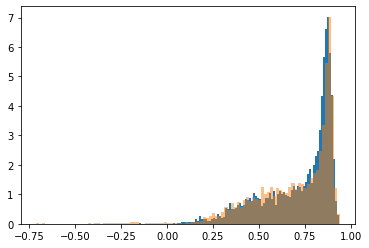

In [25]:
plt.hist(stat, density=True, bins=100)
plt.hist(stat1, density=True, bins=100,alpha=0.5);

In [25]:
Map.addLayer(evi.lt(0.1).selfMask(), {}, 'evi')

In [33]:
Map.addLayer(ndvi.lt(0.2).selfMask(), {'palette': 'blue'}, 'ndvi')

In [34]:
Map.addLayer(ndvi1.lt(0.2).selfMask(), {'palette': 'white'}, 'ndvi1')

In [30]:
Map.addLayer(ndvi.lt(0.2), {}, 'ndvi')

In [77]:
Map.addLayer(evi.gt(0.15).And(evi.lt(0.3)).selfMask(), {}, 'evi')

In [74]:
Map.addLayer(evi1.lt(0.2).selfMask(), {}, 'evi1')

In [41]:
Map.addLayer(ndvi.lt(0.2).And(ndvi.gt(0.1)).And(evi.lt(0.2)).selfMask(), {}, 'sand')

In [49]:
Map.addLayer(ndvi1.lt(0.3).And(ndvi1.gt(0.2)).And(evi1.lt(0.3)).selfMask(), {}, 'sand1')

In [26]:
Map

Map(center=[33.547818096053696, -90.3439532342821], controls=(WidgetControl(options=['position', 'transparent_…

In [4]:
# landsat classification
classLS = classification(imgLS, sclLS, method='minDis')
# obtain river mask from landsat
waterLS = classLS.eq(1)
waterLS1 = close(waterLS, 30, radius=1.5, kernelType='square', iterations=1)
riverLS = noise_removal(waterLS1, 30, 1000, 4)

In [5]:
# planet classification
classPS = classification(imgPS, sclPS, method='minDis')

In [6]:
# river mask from landsat
mask = riverLS.focal_max(1.5, iterations = 3).reproject(crs = crsLS, scale = 30)

In [7]:
# obtain river masks from planet
waterPS = classPS.eq(1).updateMask(mask)
waterPS2 = close(waterPS, 3, radius=3)
riverPS = noise_removal(waterPS2, 3, 1000, 4)

In [8]:
# fill holes of river masks
notRiver = riverPS.unmask().Not()
riverPS1 = noise_removal(notRiver, 3, 50, 4)
riverPS2 = riverPS1.unmask().Not()

In [9]:
distM = CalcDistanceMap(riverPS2, 60, sclPS)
gradM = CalcGradientMap(distM, 2, sclPS)
cl1 = CalcOnePixelWidthCenterline(riverPS2, gradM, 0.9)
k1 = ee.Kernel.fixed(3, 3, [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
clEC = cl1.selfMask().reduceNeighborhood(ee.Reducer.sum(), k1).lte(5).selfMask()
cl11 = noise_removal(clEC, 3, 500, 8)

In [10]:
# calculate centerline
cl = CalculateCenterline(riverPS2.unmask(), sclPS, thre=0.9)

In [11]:
cl = ee.Image("users/luoyee1997/geeRiver/LT/river_centerline")

In [12]:
# trim unwanted branches
trimed = trim_centerline(cl, sclPS, 300, 5).selfMask()

In [13]:
task = ee.batch.Export.image.toAsset(**{
    'image': trimed,
    'description': 'river_centerline',
    'assetId': 'users/luoyee1997/geeRiver/LT/trimed',
    'scale': 3,
    'maxPixels': 6e8,
  'region': ltb
})
task.start()

In [14]:
trimed = ee.Image("users/luoyee1997/geeRiver/LT/final_river_centerline3")

In [15]:
cl1 = ee.Image('users/luoyee1997/geeRiver/LT/CalcOnePxWdCL09')

In [16]:
k1 = ee.Kernel.fixed(3, 3, [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
clEC = cl1.selfMask().reduceNeighborhood(ee.Reducer.sum(), k1).lte(5).selfMask()

In [17]:
cl11 = noise_removal(clEC, 3, 500, 8)

In [18]:
endsByNeighbors = ExtractEndpoints(cl1px1)
joints = ExtractJoints(cl1px1)
sep = cl1px1.add(joints.unmask().focal_max(1.5, "square")).eq(1).selfMask()
costMap = (sep.cumulativeCost(
    source = endsByNeighbors,
    maxDistance = maxBranchLengthToRemove,
    geodeticDistance = True))
branchMask = costMap.gte(0).unmask(0)
cl1px1 = cl1px1.updateMask(branchMask.Not())

NameError: name 'cl1px1' is not defined

In [ ]:
endsByNeighbors = ExtractEndpoints(cl11)
joints = ExtractJoints1(cl11)
sep = cl11.add(joints.unmask().focal_max(1.5, "square")).eq(1).selfMask()

In [ ]:
costMap = (sep.cumulativeCost(
    source = endsByNeighbors,
    maxDistance = 300,
    geodeticDistance = True))
branchMask = costMap.gte(0).unmask(0)
cl1px1 = cl11.updateMask(branchMask.Not())

In [ ]:
trimed1 = CleanCenterline(cl11, 300, 3, 1)

In [ ]:
trimed1 = ee.Image("users/luoyee1997/geeRiver/LT/trimed")

In [ ]:
Map = geemap.Map()

In [ ]:
Map.addLayer(trimed.reproject(crs = crsPS, scale = 3), {'palette': 'black'}, 'trimed')

In [ ]:
#Map.addLayer(riverPS2.reproject(crs = crsPS, scale = 3),{}, 'river')
Map.addLayer(cl11.selfMask().reproject(crs = crsPS, scale = 3), {'palette': 'red'}, 'cl')
Map.addLayer(trimed1, {'palette': 'black'}, 'trimed')

In [ ]:
Map.addLayer(endsByNeighbors.reproject(crs = crsPS, scale = 3), {'palette': 'orange'}, 'eds')

In [ ]:
Map.addLayer(joints.reproject(crs = crsPS, scale = 3), {'palette': 'blue'}, 'joints')

In [ ]:
Map.addLayer(sep.reproject(crs = crsPS, scale = 3), {'palette': 'orange'}, 'sep')

In [ ]:
Map.addLayer(cl1px1.selfMask().reproject(crs = crsPS, scale = 3), {'palette': 'yellow'}, 'cl1px1')

In [ ]:
Map